<a href="https://colab.research.google.com/github/MatheusRocha0/Demand-Forecasting/blob/main/US_Demand_For_Gasoline_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand For Gasoline Forecasting 
 
Time Series forecasting is one of the most commonly used applications of Data Science in the world. Because it is very useful I can be used on many areas. 
 
In this project, I will analyze and also build a statistical model able to forecast the demand for gasoline in the United States.
 
There are different ways to forecast demand using Machine Learning:
 
**Regression:** when the value we want to predict is influenced by other factors like time, it is interesting to use Regression Machine Learning algorithms like Linear Regression.
 
**Moving Average**: when the value is not influenced by other factors it is necessary to use another approach, like using ARIMA and Facebook Prophet. These methods only use previous values in the time series to make forecasts.
 
Since the time serie we want to predict probably does not have any seasonal behavior, I am going to use an ARIMA approach.
 
# About the Dataset
 
The dataset I will be using in this project brings informations about gasoline in United States, such as demand and production in different locations.
 
**Here is the link to download this dataset for your own purposes:** https://bit.ly/3oAcrmj

 # Importing

## Libraries

In [2]:
import numpy             as np
import pandas            as pd
import seaborn           as sb
import matplotlib.pyplot as plt
 
from statsmodels.tsa.stattools     import adfuller, acf
from statsmodels.tsa.arima_model   import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data

In [3]:
url = "https://raw.githubusercontent.com/MatheusRocha0/Demand_Forecasting/main/Transportation_Fuels_Production_and_Demand__Beginning_1993.csv"
data = pd.read_csv(url)
new_names = ["date", "east_cost_gas_prod", "east_cost_fuel_prod", "us_gas_prod", "us_gas_demand", "us_fuel_prod"]
data.columns = new_names
data.head()

,date,east_cost_gas_prod,east_cost_fuel_prod,us_gas_prod,us_gas_demand,us_fuel_prod
0,10/30/2020,2914,22.0,9072,8336,919
1,10/23/2020,2986,13.0,9095,8545,840
2,10/16/2020,2909,20.0,8933,8289,782
3,10/09/2020,3030,20.0,9240,8576,749
4,10/02/2020,2864,23.0,9522,8896,799


## Jupyter Notebook Setting

In [10]:
def jupyter_settings():
   %matplotlib inline
   %pylab inline
   sb.set_style("whitegrid")
   sb.set_palette("Greys")
   sb.set()
   plt.rcParams["figure.figsize"] = [20, 20]
 
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


 # Data Cleaning

## Missing Values

In [4]:
data.isnull().sum()

date                   0
east_cost_gas_prod     0
east_cost_fuel_prod    1
us_gas_prod            0
us_gas_demand          0
us_fuel_prod           0
dtype: int64

Imputing Missing Values

In [5]:
data[data.columns[2]].fillna(data.east_cost_fuel_prod.mean(), inplace = True)

## Dropping Duplicates

In [6]:
data.drop_duplicates(inplace = True)

 
## Date
 
1. Turning Date variable into datetime (special Pandas variable type to work with date)
 
2. Setting it as index
 
3. Sorting it

In [7]:
data.date = pd.to_datetime(data.date)
data.set_index("date", inplace = True)
data.sort_index(inplace = True)

# Exploratory Data Analysis (EDA)

## Statistics

In [8]:
data.us_gas_demand.describe()

count    1425.000000
mean     8740.369123
std       657.499739
min      5065.000000
25%      8369.000000
50%      8867.000000
75%      9206.000000
max      9932.000000
Name: us_gas_demand, dtype: float64

**Stardard Deviation (std)**: it is a statistic that measures the variance in a variable compared to the mean.
 
**Mean**: a measure of central tendency that is the result of the sum of values divided by its length.
 
**25%, 50% and 75%**: these statistics are called Quartiles or even Percentiles, and they stands for the max value for x% of the data.

## Variables Distribution

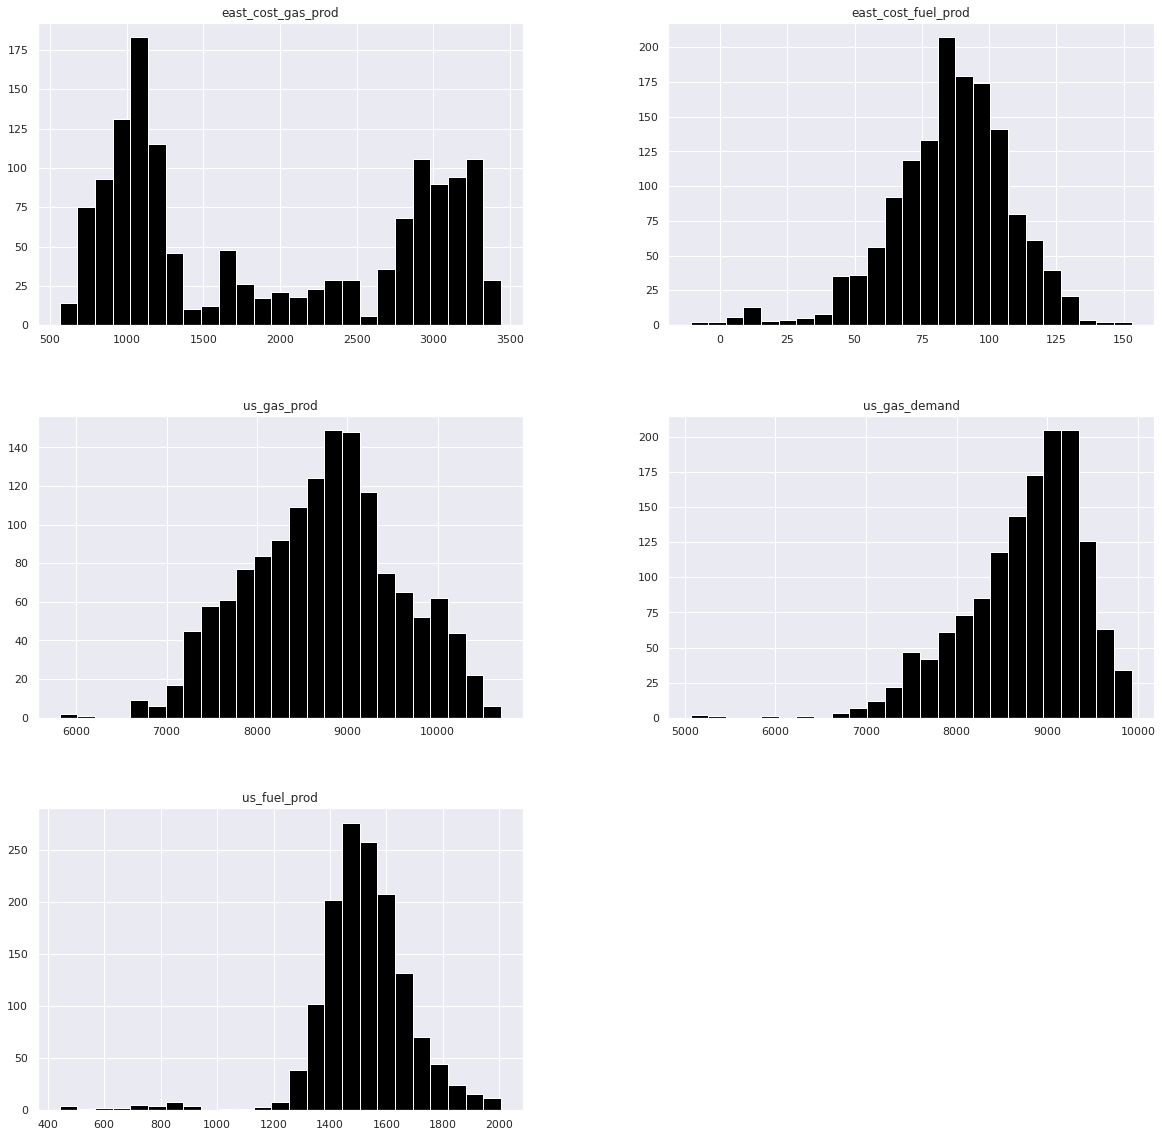

In [11]:
data.hist(color = "black", figsize = (20, 20), bins = 25)
plt.show()

These charts are histograms and they represent the variable distribution.
 
Most of them have a Normal/Gaussian Distribution. While the *east_cost_fuel_prod* has a uniform distribution

## Correlation between variables

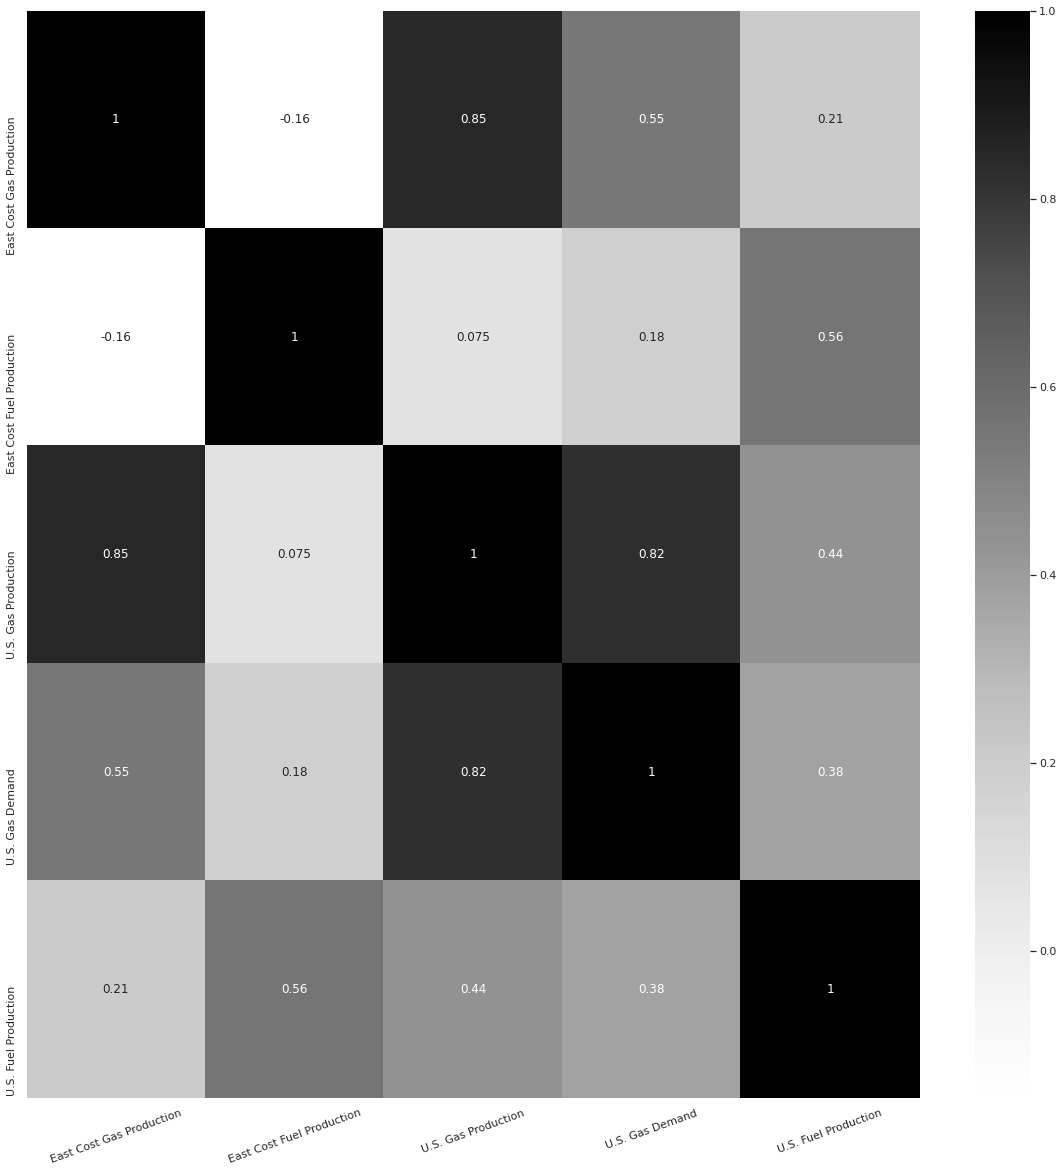

In [13]:
labels = ["East Cost Gas Production", "East Cost Fuel Production", "U.S. Gas Production", "U.S. Gas Demand", "U.S. Fuel Production"]
 
sb.heatmap(data.corr(), annot = True, square = False, xticklabels = labels, yticklabels = labels, cmap = "Greys")
plt.xticks(rotation = 20)
plt.show()

This plot is a Heatmap and it represents the correlation, in this case, the Pearson Correlation, between variables.
 
A dark color represents a strong correlation while a light color represents a week correlation. It varies from -1 (negative correlation) until 1 (positive correlation). This also may be 0, the worst scenario.
 
There is no a strong correlation between U.S. Gas Demand and another variable. Saying Demand is influenced by Production is wrong, but saying Production is influenced by Demand is right.

## U.S. Gas Demand Variable Time Serie

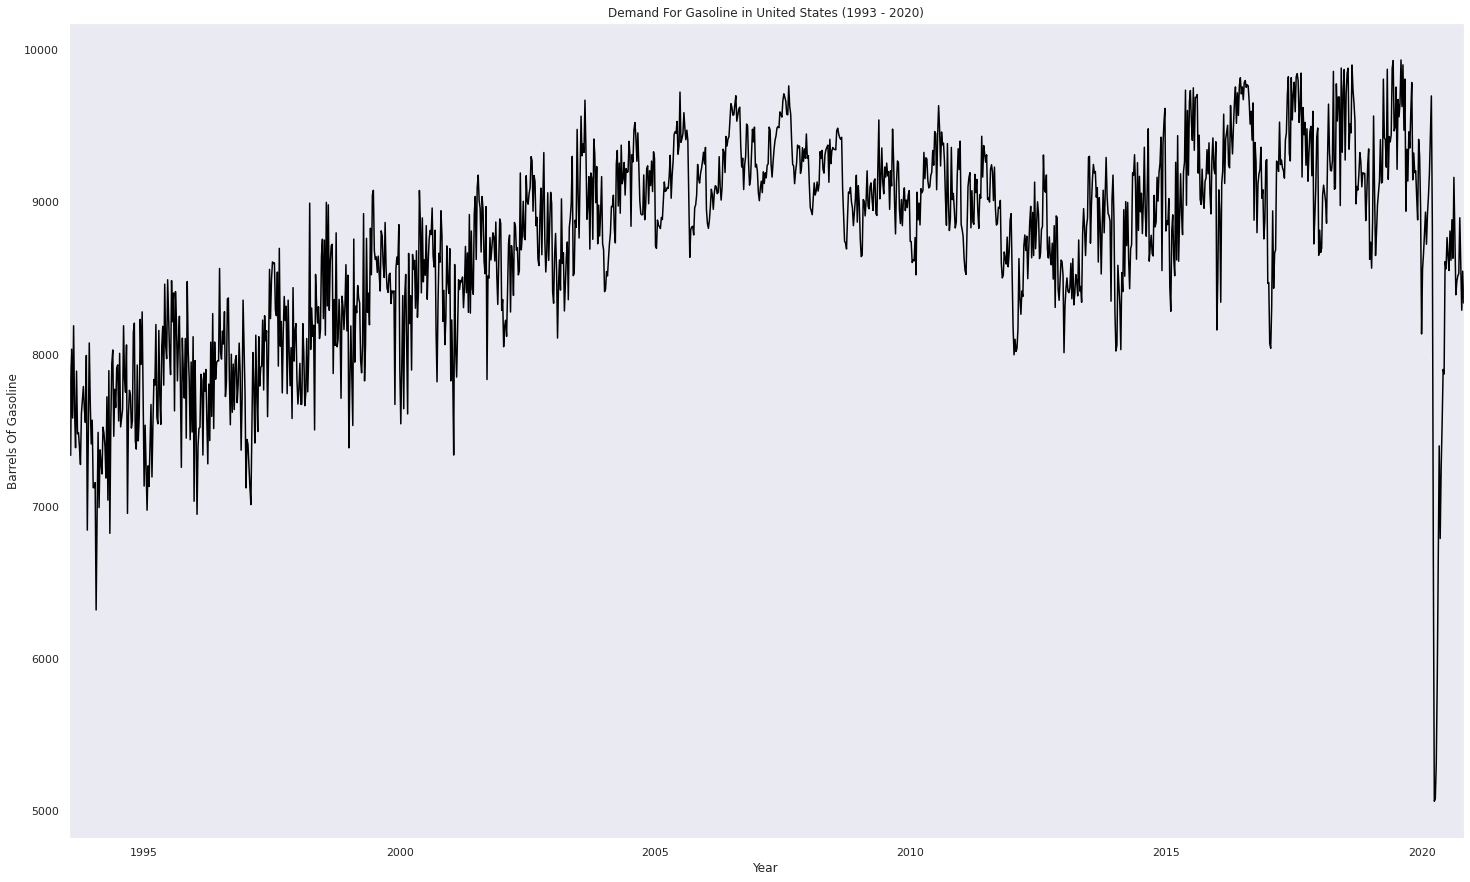

In [14]:
data.us_gas_demand.plot(figsize = (25, 15), color = "black")
plt.title("Demand For Gasoline in United States (1993 - 2020)")
plt.xlabel("Year")
plt.ylabel("Barrels Of Gasoline")
plt.grid(False)
plt.show()

This line plot shows the demand for gas from 1993 until 2020. It is possible to see an outlier at the beginning of 2020 due the Covid-19 Pandemic. But it is hard to analyze a long time serie, let's solve this problem by grouping the data.

## Time Serie Grouped By Year

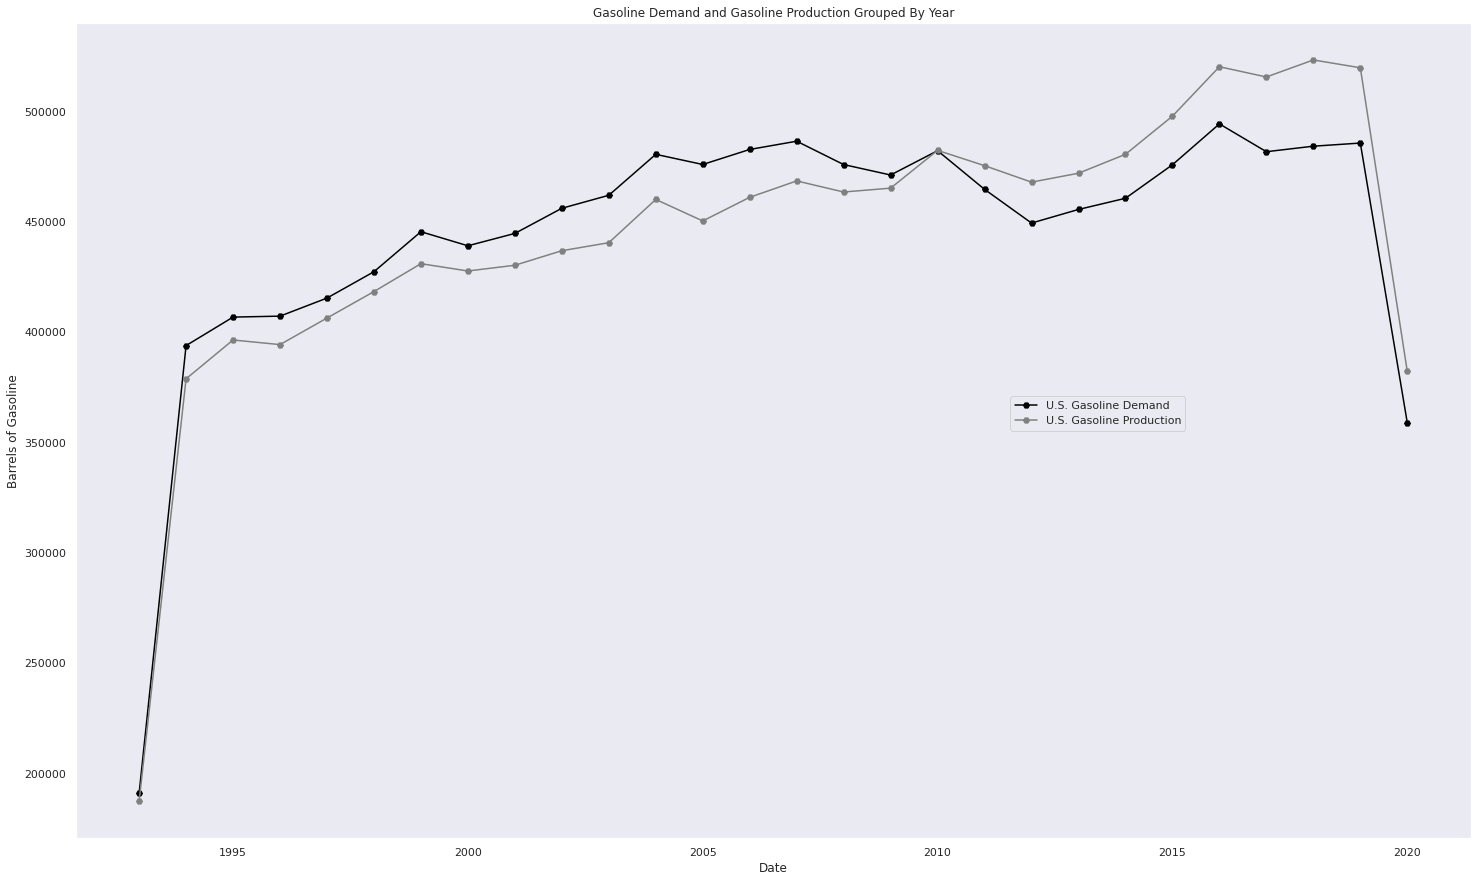

In [15]:
data.groupby(data.index.year)[["us_gas_demand", "us_gas_prod"]].sum().plot(figsize = (25, 15), marker = "H", color = ["black", "gray"])
plt.title("Gasoline Demand and Gasoline Production Grouped By Year")
plt.xlabel("Date")
plt.ylabel("Barrels of Gasoline")
plt.legend(["U.S. Gasoline Demand", "U.S. Gasoline Production"], fancybox = True, loc = (.67, .5))
plt.grid(False)
plt.show()

Here, the variables arw grouped by year, so it is easier to analyze.

It is interesting to see that after 2010, the production is always bigger than the demand, what is a good thing.

## Demand Difference

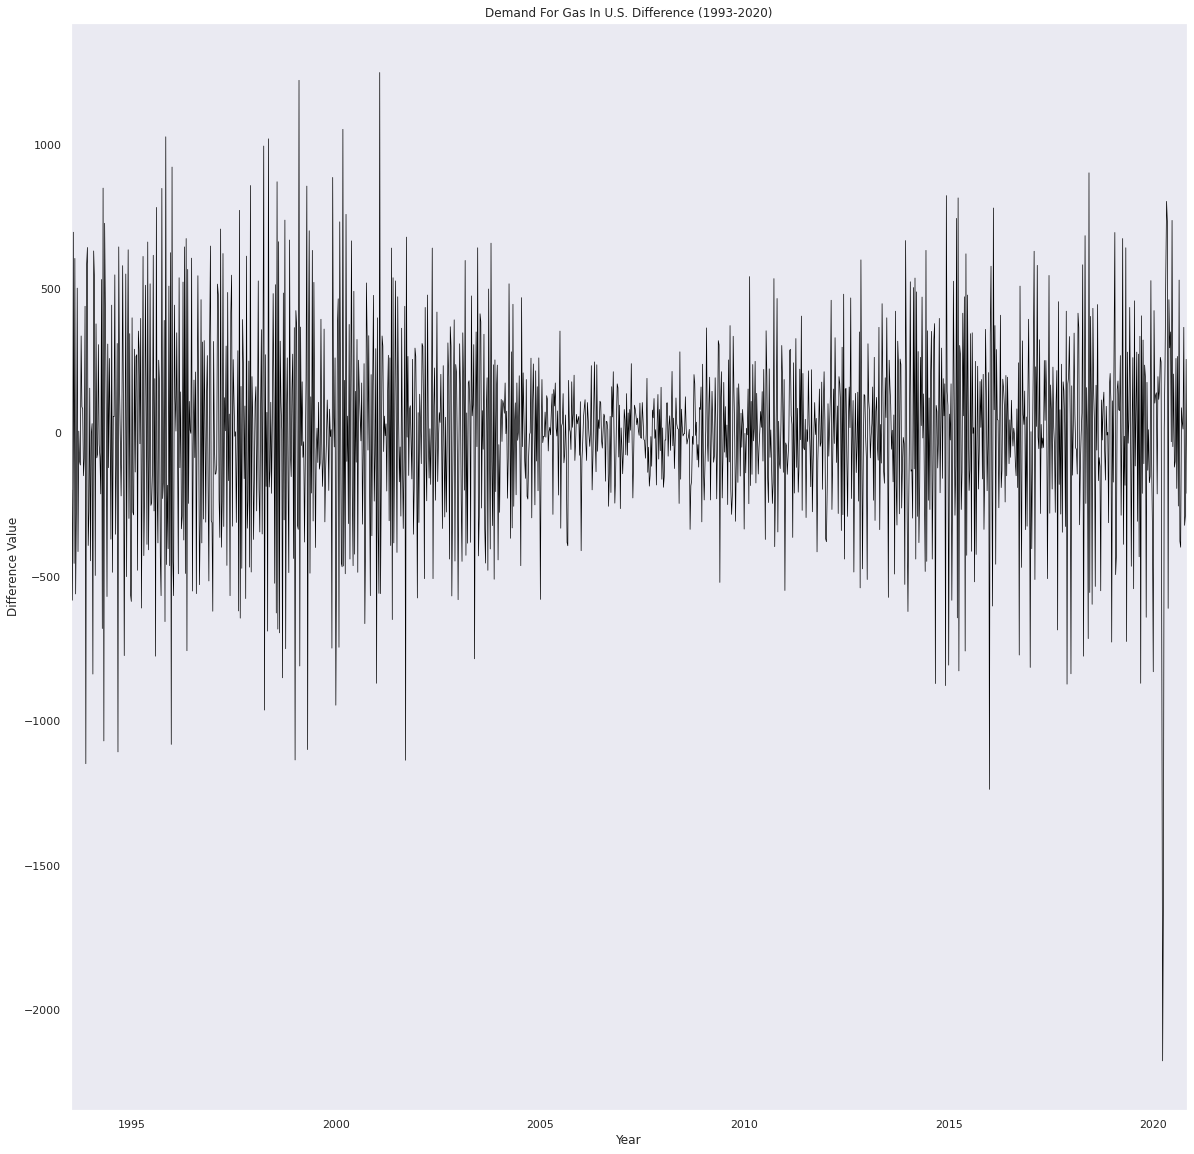

In [16]:
data.us_gas_demand.diff().plot(color = "black", figsize = (20, 20), linewidth = .7)
plt.title("Demand For Gas In U.S. Difference (1993-2020)")
plt.xlabel("Year")
plt.ylabel("Difference Value")
plt.grid(False)
plt.show()

*.diff()* function returns the difference between last and current value in a list of values. But, just like the previous case, it is also hard to visualize this plot, so will plot it another way.

## Demand Difference Grouped By Year

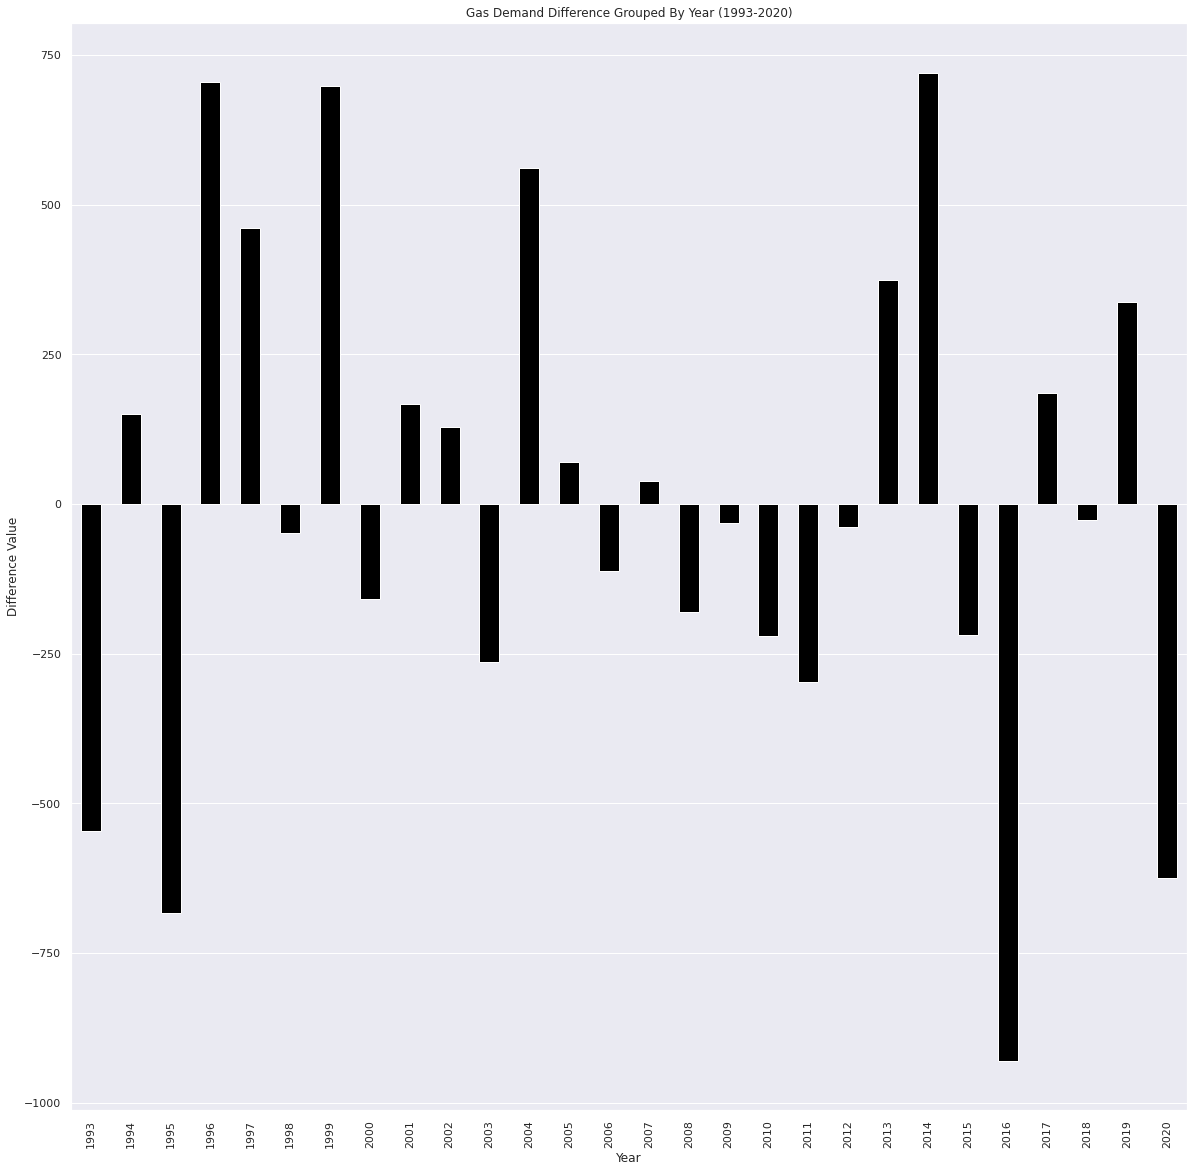

In [18]:
data.us_gas_demand.diff().groupby(data.index.year).sum().plot(color = "black", kind = "bar", figsize = (20, 20))
plt.title("Gas Demand Difference Grouped By Year (1993-2020)")
plt.xlabel("Year")
plt.ylabel("Difference Value")
plt.grid(axis = "x")
plt.show()

Now it is easier to see how the values grouped by year vary.

# Building the Model

The ARMA model, a Statistcal model used for Time Series Forecasting needs two parameters: p and q. There are steps to follow to decide the value for each of them.

## P (Partial Autocorrelation)

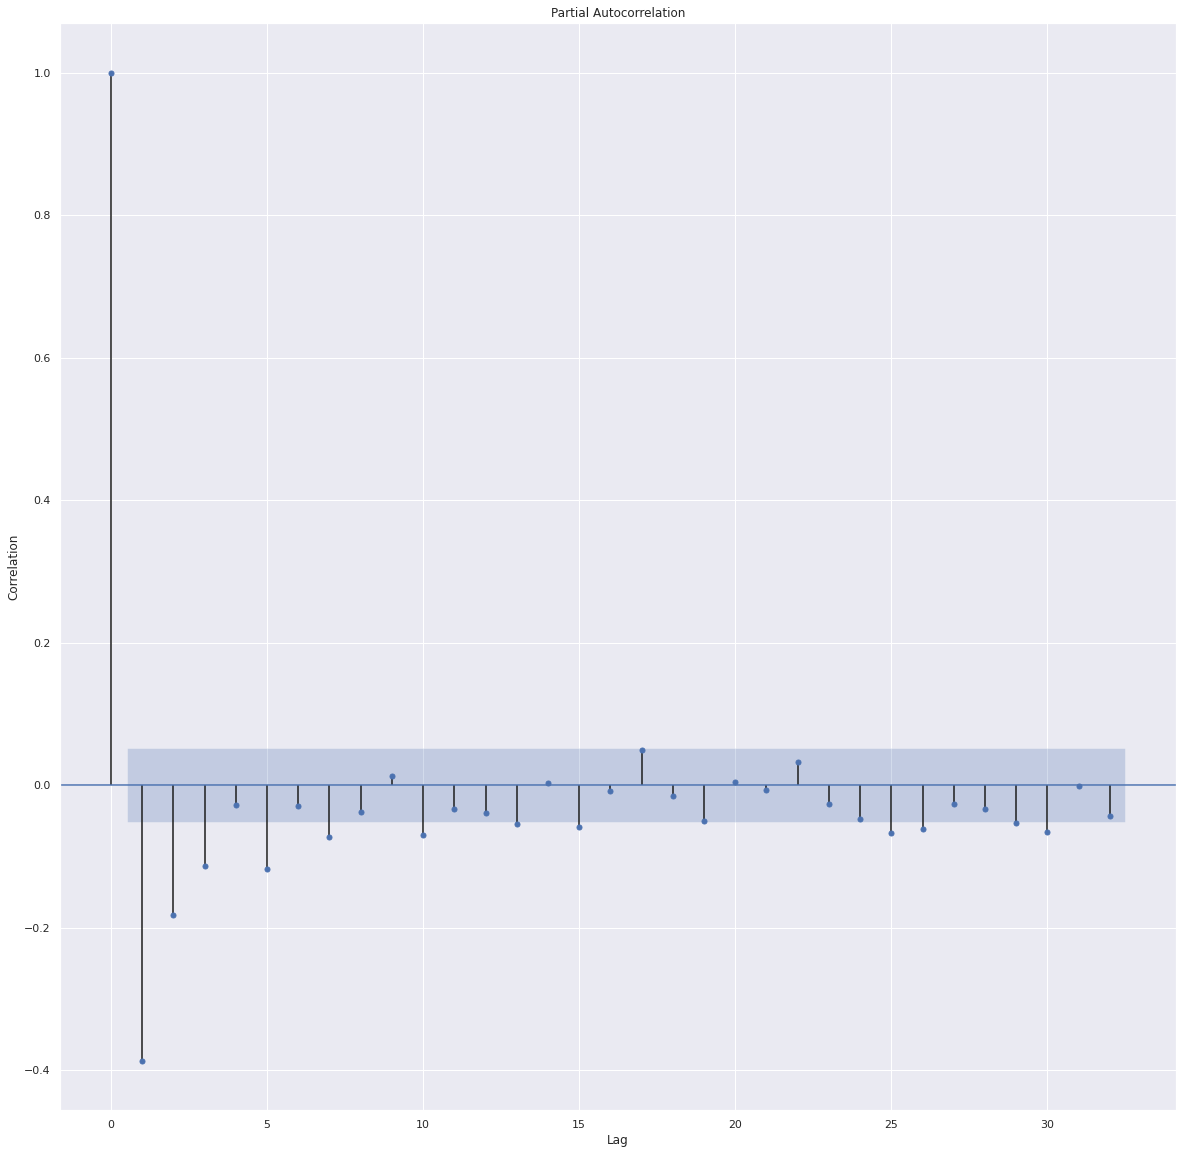

In [19]:
plot_pacf(data.us_gas_demand.diff().dropna())
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

 A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

## Q (Autocorrelation)

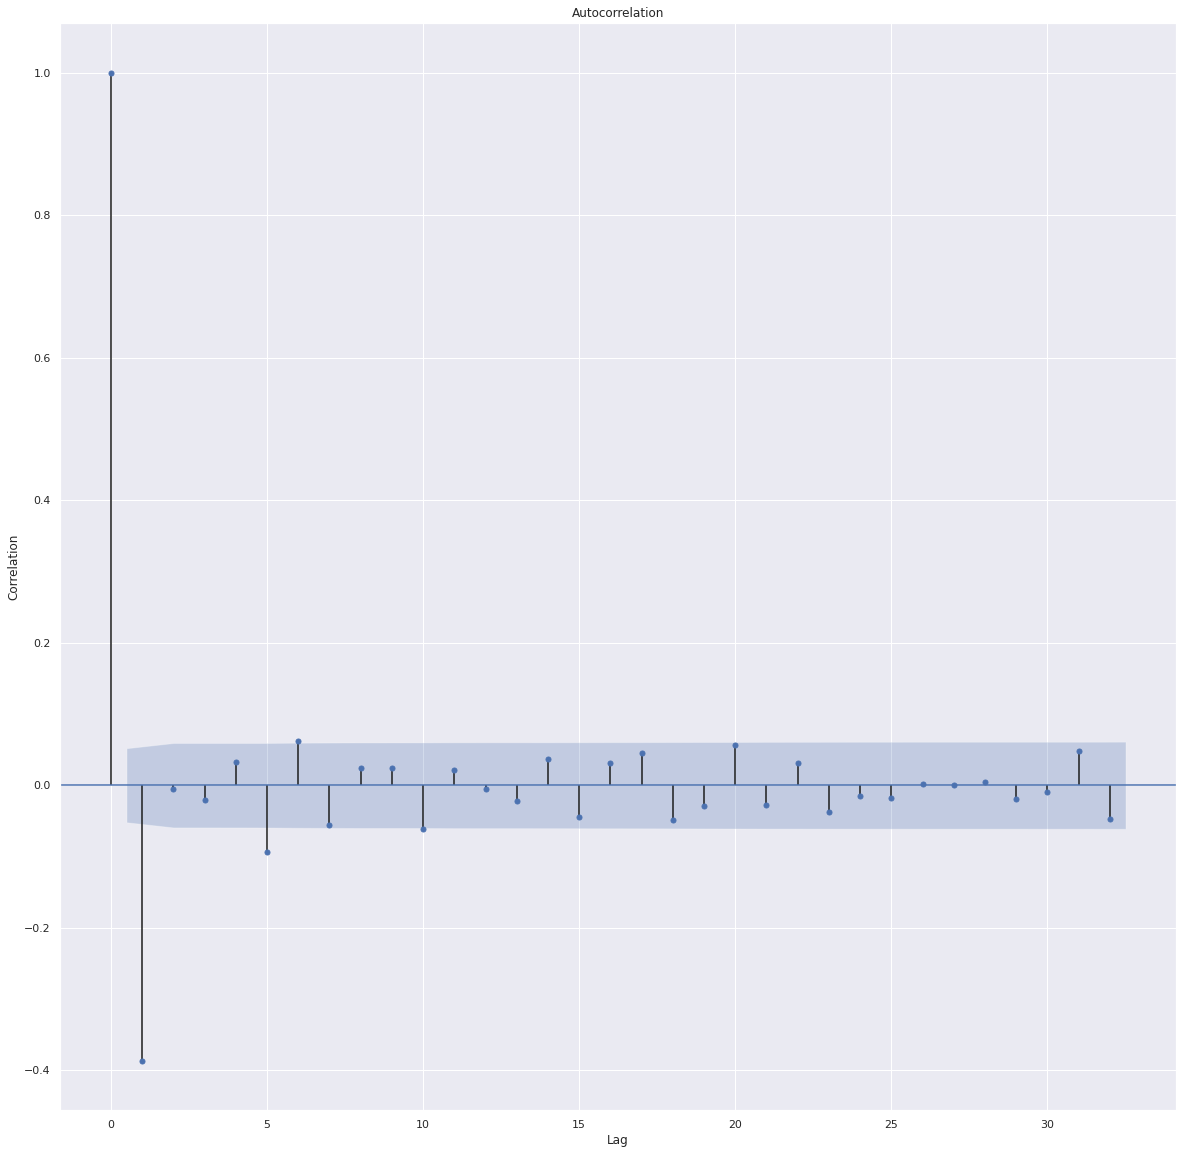

In [20]:
plot_acf(data.us_gas_demand.diff().dropna())
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.

## ARMA (Autoregressive Moving-Average)

The autoregressive-moving average (ARMA) process is the basic model for analyzing a stationary time series.

## Model

 
### Testing
 
In this step, I will build a test model and evaluate its accuracy with a specific order nd then train the final model using this order.
 
### Metrics
 
**MAPE (Mean Absolute Percentage Error)**: it is a evaluation metric for Time Series and Regression tasks. Equation:

$Real - Predictions ÷ Real$
 
The lower the better.
 
**Accuracy**: it is the same accuracy metric used in Classification tasks. Equation:
 
$100 - MAPE$
 
The greater the better.

In [21]:
train = data.us_gas_demand.loc[data.index.year < 2010]
test = data.us_gas_demand.loc[data.index.year > 2010]
test_model = ARMA(train, freq = "W-FRI", order = (6, 2)).fit()
forecasting = test_model.forecast(len(test), alpha = .01)[0]
mape = np.mean(np.abs((test - forecasting) / test))
mape = round(mape * 100)
accuracy = 100 - mape
print(accuracy, "% of Accuracy")

95 % of Accuracy


### Final Model And Forecasting

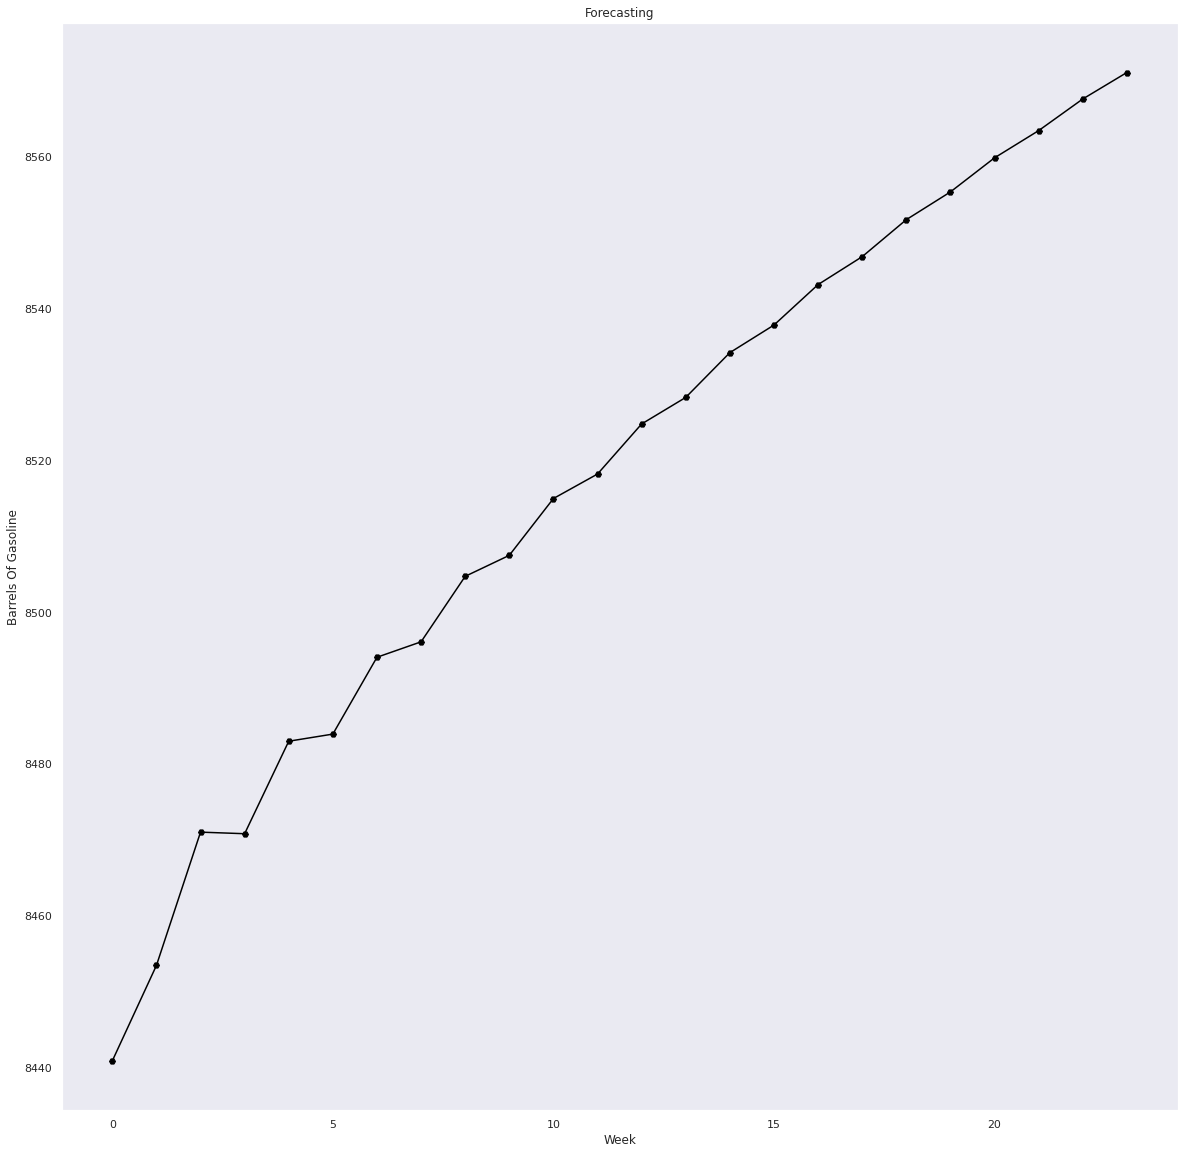

In [22]:
final_model = ARMA(data.us_gas_demand, freq = "W-FRI", order = (3, 2)).fit(disp = -1)
n_inters = 24
forecasts = final_model.forecast(n_inters, alpha = .01)[0]
 
plt.plot(forecasts, marker = "H", color = "black")
plt.title("Forecasting")
plt.xlabel("Week")
plt.ylabel("Barrels Of Gasoline")
plt.grid(False)
plt.show()

I selected 24 as the number of interations for forecasting

### Forecasting And Real Values

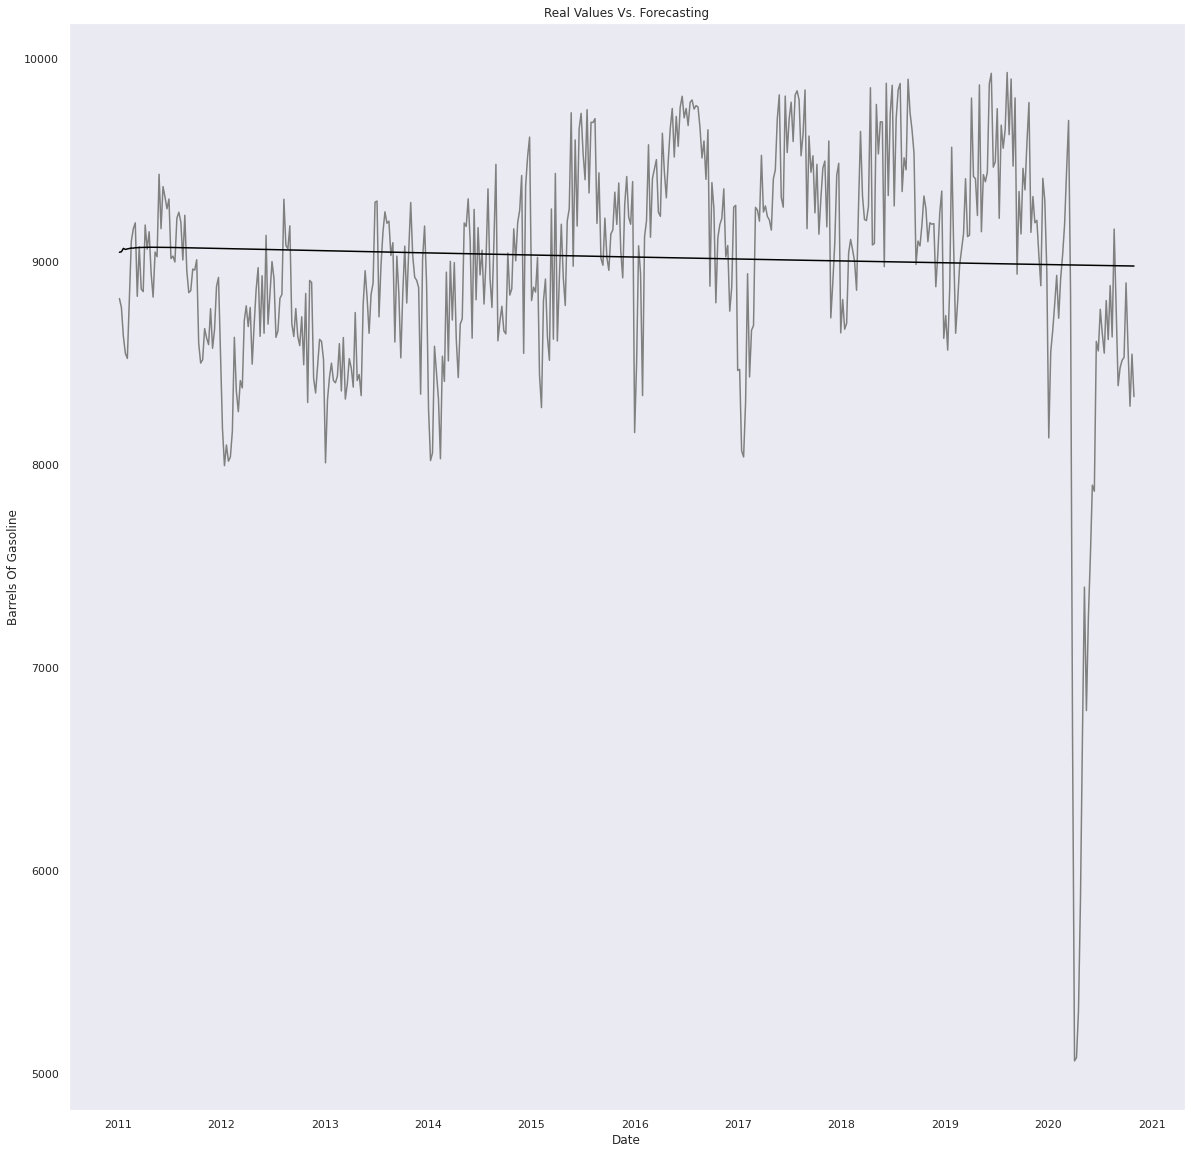

In [23]:
plt.plot(test.index, test, label = "Real", color = "gray")
plt.plot(test.index, forecasting, label = "Predicted", color = "black")
plt.title("Real Values Vs. Forecasting")
plt.xlabel("Date")
plt.ylabel("Barrels Of Gasoline")
plt.grid(False)
plt.show()

Now I trained the final model using the entire variable and made forecasts using it. You can even see the results on the plot above.
 
The number of iterations I selected is 24, because I think it is a good number considering the number of observations in the dataset and model's performance. Greater the number of iterations greater the error, what is not interesting.
 
The line across the time serie is the model's fitting process. This may look stranger, but this is how Machine Learning models work. The bias prevent the line turn into a curve. But is still good because this allows the model make reliable predictions in future data.
 
## Confidence Interval
 
In statistics, a confidence interval (CI) is a type of estimate computed from the statistics of the observed data. This proposes a range of plausible values for an unknown parameter(for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range.
 
I used a Confidence Interval of 99% to do the forecasts using the model. Frequentists and Bayesians have different approachs about this subject. But, considering a classic Statistics, this is something like: the forecasts are 99% correct.

### Training Process
 
This plot shows the training process and accurate it is over the time serie. There are two different lines in this plot, if you have difficult to see it means the training line is very similar to the true line.

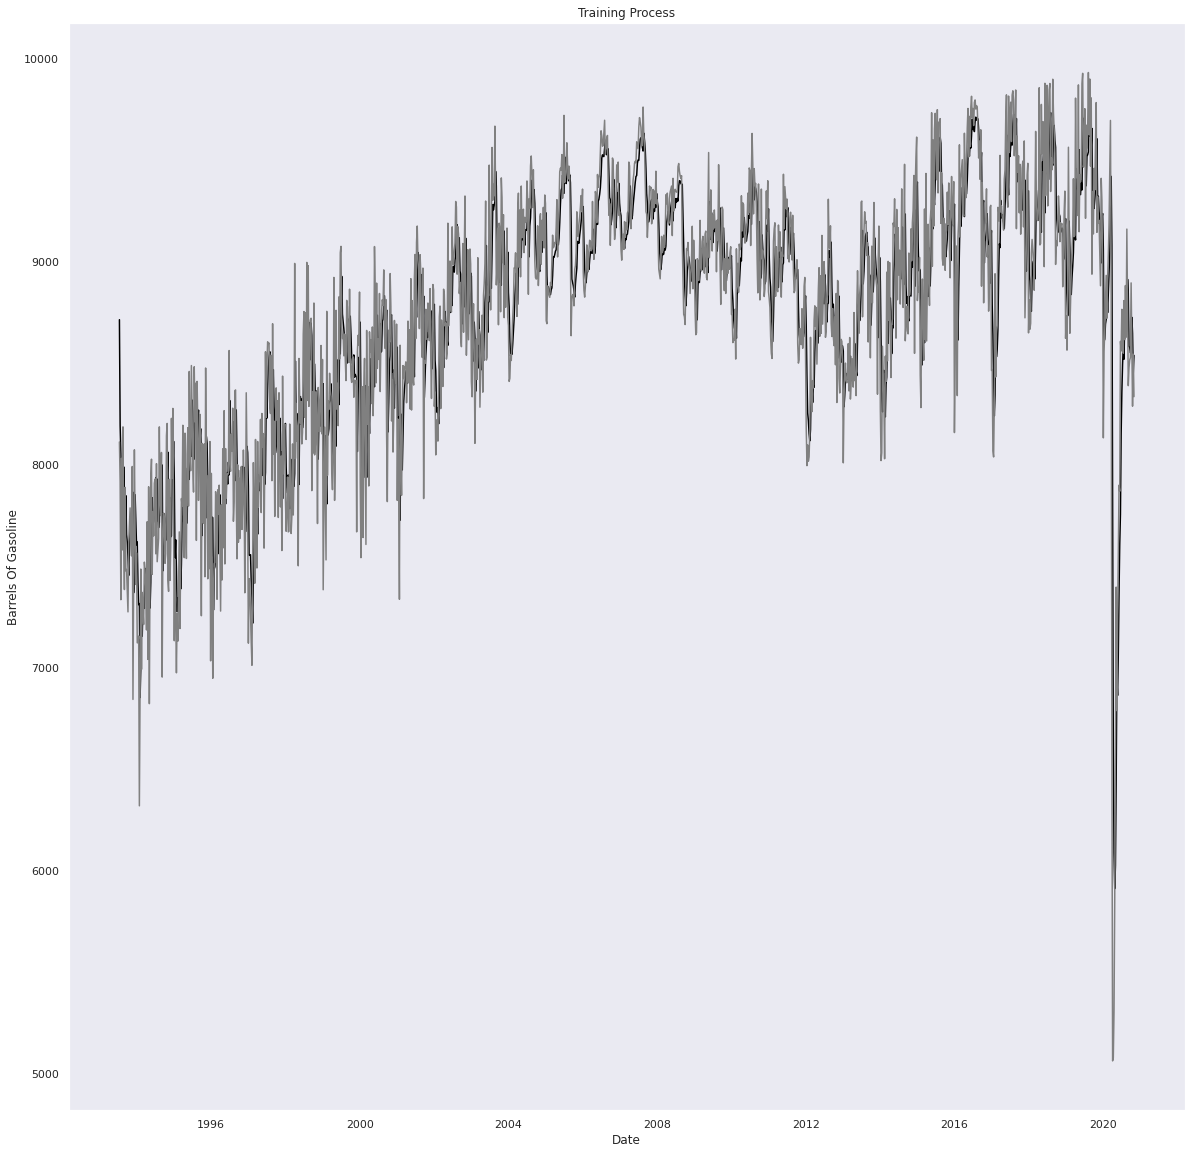

In [24]:
plt.plot(data.index, final_model.predict(), color = "black")
plt.plot(data.index, data.us_gas_demand, color = "gray")
plt.title("Training Process")
plt.xlabel("Date")
plt.ylabel("Barrels Of Gasoline")
plt.grid(False)
plt.show()

## Forecasts Table
 
Here, some statistical informations about the forecasting

In [25]:
forecast_df = pd.Series(forecasts)
forecast_df.describe()

count      24.000000
mean     8517.677449
std        37.426153
min      8440.899761
25%      8491.574869
50%      8521.559521
75%      8548.132221
max      8571.188884
dtype: float64

## Residuals

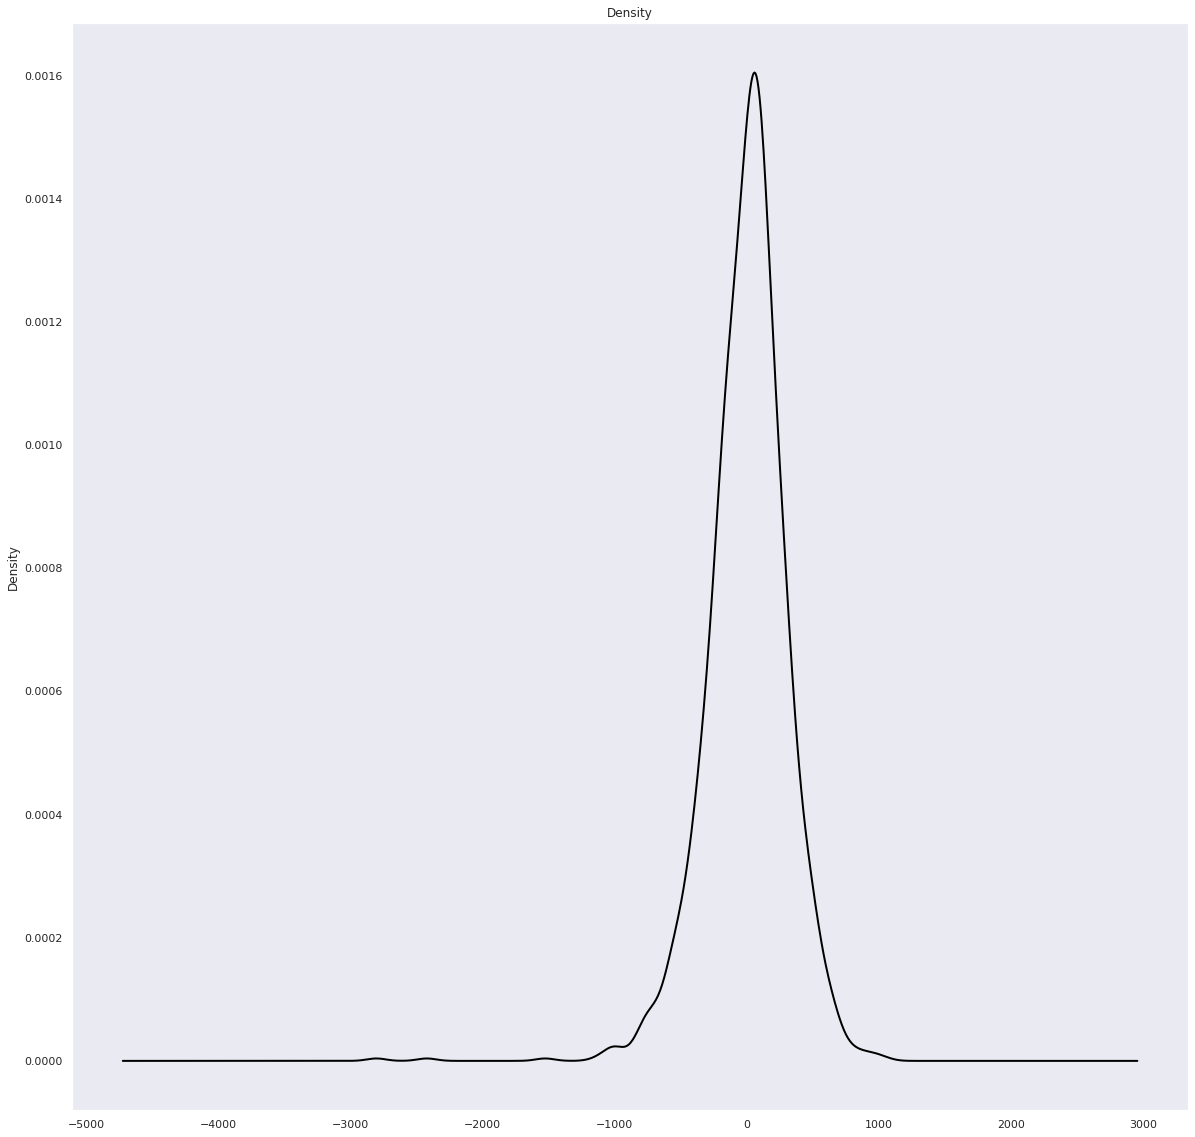

In [26]:
residuals = pd.DataFrame(final_model.resid)
residuals.plot(color = "black", kind = "density", title = "Density", legend = False, figsize = (20, 20), xlabel = "Tendency", ylabel = "Difference", linewidth = 2)
plt.grid(False)
plt.show()

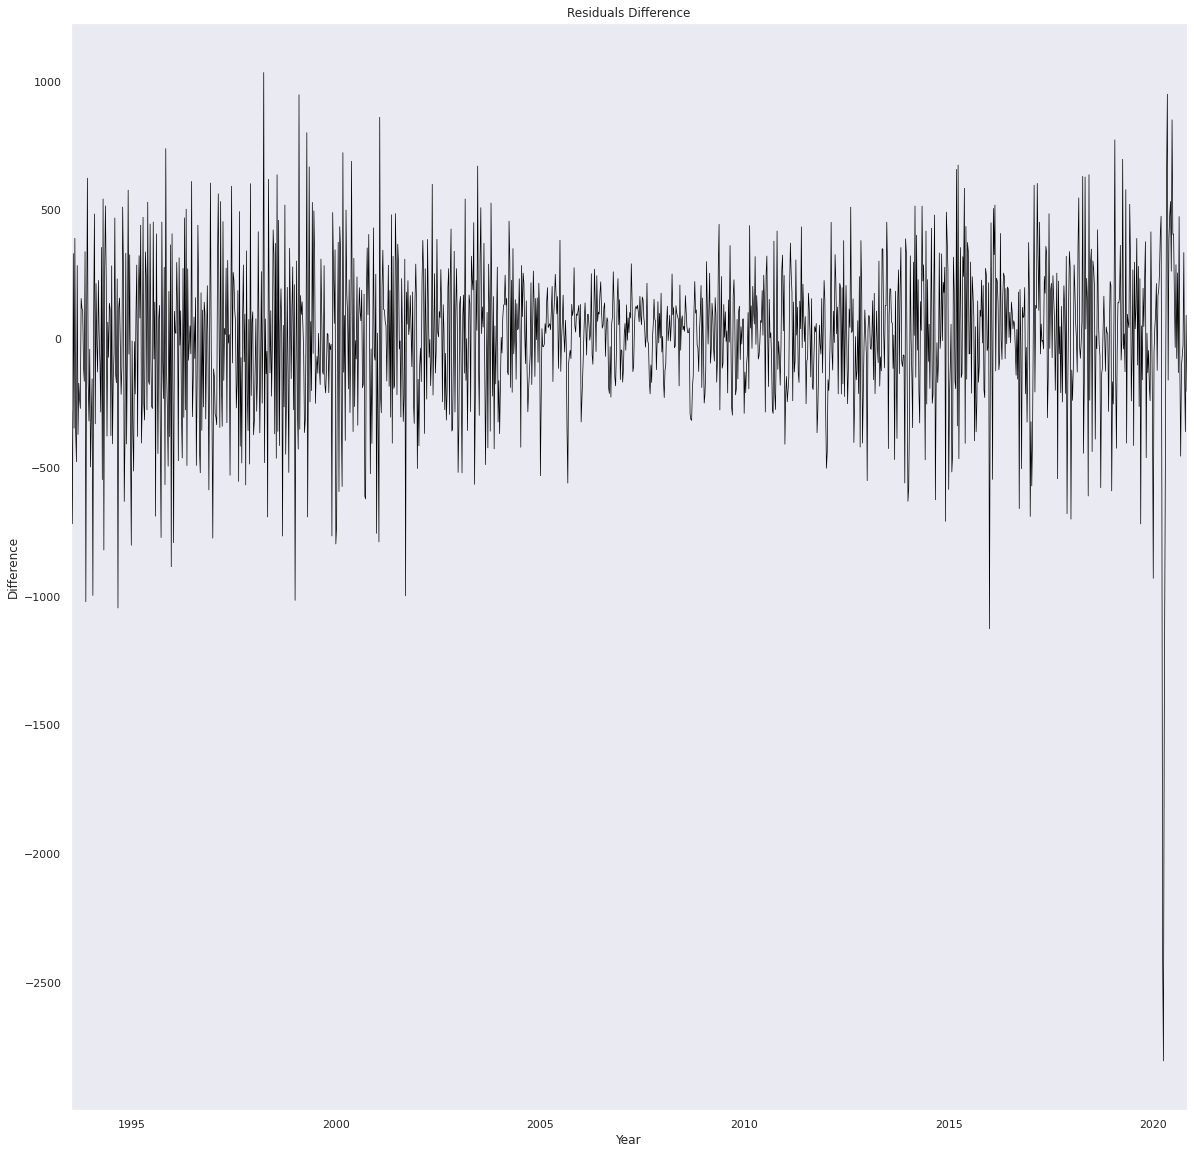

In [27]:
residuals.plot(color = "black", figsize = (20, 20), linewidth = .7, title = "Residuals Difference", xlabel = "Year", ylabel = "Difference", legend = False)
plt.grid(False)
plt.show()

These two plots above are about the model's residuals that explain what happened on the training process.
 
**First**: the errors tend to zero.

**Second**: the difference in the residuals.

# Deploy
 
In order to make the results more avaiable, I deployed this model as a Telegram Chatbot I called GasBot (@gasforecasting_bot). Anyone may access it and see the results.

The only thing you need to do is start a chat with it and enter "/return" and then it will return a plot with the predictions for the next weeks.